In [2]:
%matplotlib inline
import polars as pl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [3]:
langs = pl.read_csv('data/World_Languages.csv')
langs[0:5]

X,Y,OBJECTID,SOVEREIGNT,TYPE_,COUNTRY,FIRST_OFFI,SECOND_OFF,THIRD_OFFI,ENGLISH_FI,FRENCH_FIR,ARABIC_FIR,SPANISH_FI,PORTUGUESE,CHINESE_FI,RUSSIAN_FI,WORLD_LANG
f64,f64,i64,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,str
24.471441,-22.345302,20,"""Botswana""","""Sovereign country""","""Botswana""","""English""",null,null,1,0,0,0,0,0,0,"""English"""
20.633118,6.614791,21,"""Central African Republic""","""Sovereign country""","""Central African Republic""","""French""","""Sangho""",null,0,1,0,0,0,0,0,"""French"""
-110.430879,56.836921,22,"""Canada""","""Sovereign country""","""Canada""","""English""","""French""",null,1,1,0,0,0,0,0,"""English_French"""
-69.684882,67.856696,22,"""Canada""","""Sovereign country""","""Canada""","""English""","""French""",null,1,1,0,0,0,0,0,"""English_French"""
-76.784377,79.622971,22,"""Canada""","""Sovereign country""","""Canada""","""English""","""French""",null,1,1,0,0,0,0,0,"""English_French"""


In [4]:
continents = pl.read_csv('data/Countries_Continents.csv')
continents[0:5]

Continent,Country
str,str
"""Africa""","""Algeria"""
"""Africa""","""Angola"""
"""Africa""","""Benin"""
"""Africa""","""Botswana"""
"""Africa""","""Burkina Faso"""


In [66]:
print(langs.schema)
print(continents.schema)

Schema([('X', Float64), ('Y', Float64), ('OBJECTID', Int64), ('SOVEREIGNT', String), ('TYPE_', String), ('COUNTRY', String), ('FIRST_OFFI', String), ('SECOND_OFF', String), ('THIRD_OFFI', String), ('ENGLISH_FI', Int64), ('FRENCH_FIR', Int64), ('ARABIC_FIR', Int64), ('SPANISH_FI', Int64), ('PORTUGUESE', Int64), ('CHINESE_FI', Int64), ('RUSSIAN_FI', Int64), ('WORLD_LANG', String)])
Schema([('Continent', String), ('Country', String)])


# FRENCH

In [67]:
french=langs.filter(((langs['FIRST_OFFI'] == 'French') | (langs['SECOND_OFF'] == 'French')) 
                    & ((langs['TYPE_'] == 'Sovereign country')|(langs['TYPE_'] == 'Country'))
                    & (langs['SOVEREIGNT'] == langs['COUNTRY'])
                    )
print(french['COUNTRY'].n_unique())
french['COUNTRY'].unique().sort()

29


COUNTRY
str
"""Algeria"""
"""Belgium"""
"""Benin"""
"""Burkina Faso"""
"""Burundi"""
…
"""Niger"""
"""Rwanda"""
"""Senegal"""


In [68]:
countries_with_continents = french.join(
    continents,
    left_on='COUNTRY',
    right_on='Country',
    how='left'
).select([
    'COUNTRY',
    'Continent'
]).unique().sort(pl.col('Continent'))  # Remove duplicates if any

print("Countries and their Continents:")
countries_with_continents

Countries and their Continents:


COUNTRY,Continent
str,str
"""Rwanda""","""Africa"""
"""Congo""","""Africa"""
"""Senegal""","""Africa"""
"""Burundi""","""Africa"""
"""Ivory Coast""","""Africa"""
…,…
"""Monaco""","""Europe"""
"""Luxembourg""","""Europe"""
"""Switzerland""","""Europe"""


In [69]:
countries_per_continent = french.join(
    continents,
    left_on='COUNTRY',
    right_on='Country',
    how='left'
).group_by('Continent')\
 .agg(
     pl.col('COUNTRY').n_unique().alias('country_count')
 )\
 .sort('country_count', descending=True)

countries_per_continent

Continent,country_count
str,u32
"""Africa""",22
"""Europe""",5
"""North America""",2


# ENGLISH

In [70]:
english=langs.filter(((langs['FIRST_OFFI'] == 'English') | (langs['SECOND_OFF'] == 'English')) 
                    & ((langs['TYPE_'] == 'Sovereign country')|(langs['TYPE_'] == 'Country'))
                    & (langs['SOVEREIGNT'] == langs['COUNTRY'])
                    )
print(english['COUNTRY'].n_unique())
english['COUNTRY'].unique().sort()

53


COUNTRY
str
"""Antigua and Barbuda"""
"""Australia"""
"""Barbados"""
"""Belize"""
"""Botswana"""
…
"""Uganda"""
"""United Kingdom"""
"""United States"""


In [71]:
countries_with_continents = english.join(
    continents,
    left_on='COUNTRY',
    right_on='Country',
    how='left'
).select([
    'COUNTRY',
    'Continent'
]).unique().sort(pl.col('Continent'))  # Remove duplicates if any

print("Countries and their Continents:")
countries_with_continents

Countries and their Continents:


COUNTRY,Continent
str,str
"""Tanzania""","""Africa"""
"""Swaziland""","""Africa"""
"""Liberia""","""Africa"""
"""Sierra Leone""","""Africa"""
"""Ghana""","""Africa"""
…,…
"""Palau""","""Oceania"""
"""Vanuatu""","""Oceania"""
"""Fiji""","""Oceania"""


In [72]:
countries_per_continent = english.join(
    continents,
    left_on='COUNTRY',
    right_on='Country',
    how='left'
).group_by('Continent')\
 .agg(
     pl.col('COUNTRY').n_unique().alias('country_count')
 )\
 .sort('country_count', descending=True)

countries_per_continent

Continent,country_count
str,u32
"""Africa""",20
"""North America""",12
"""Oceania""",12
"""Asia""",4
"""Europe""",4
"""South America""",1


In [8]:
def plot_countries(df, title):    
        ax = plt.axes(projection=ccrs.PlateCarree())

        ax.coastlines()
        ax.set_global() #sshow the entire map; otherwise it auto-zooms based on the points

        ax.plot(df['X'], 
                df['Y'], 
                'bs',  #blue squares
                transform=ccrs.Geodetic(), 
                markersize=5)

        plt.title(title)
        plt.show()

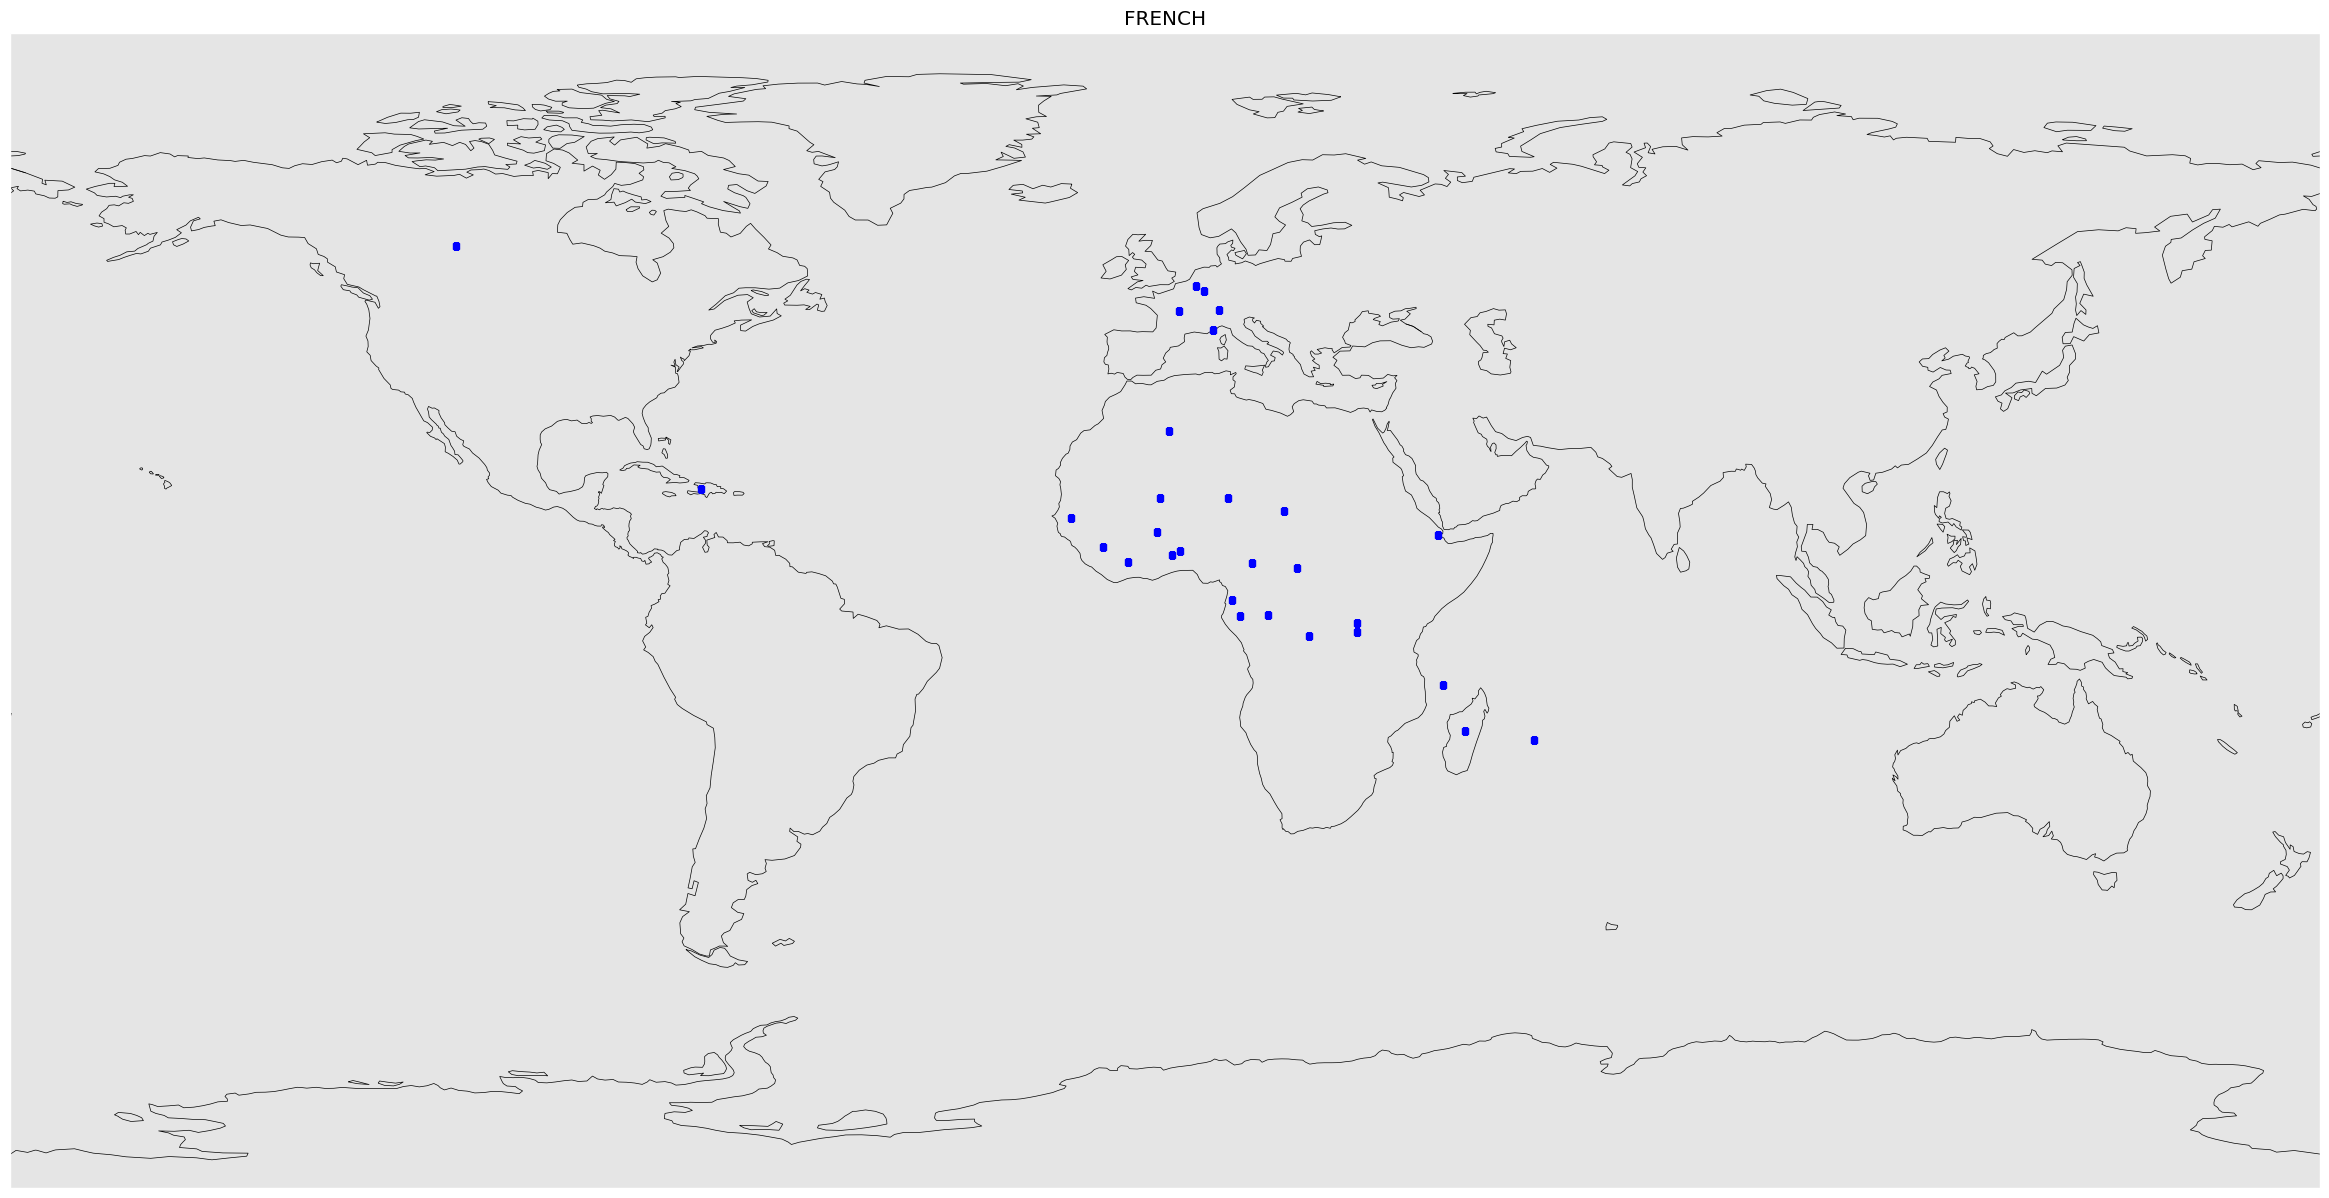

In [81]:
plot_countries(french.group_by("COUNTRY").first(), 'FRENCH')

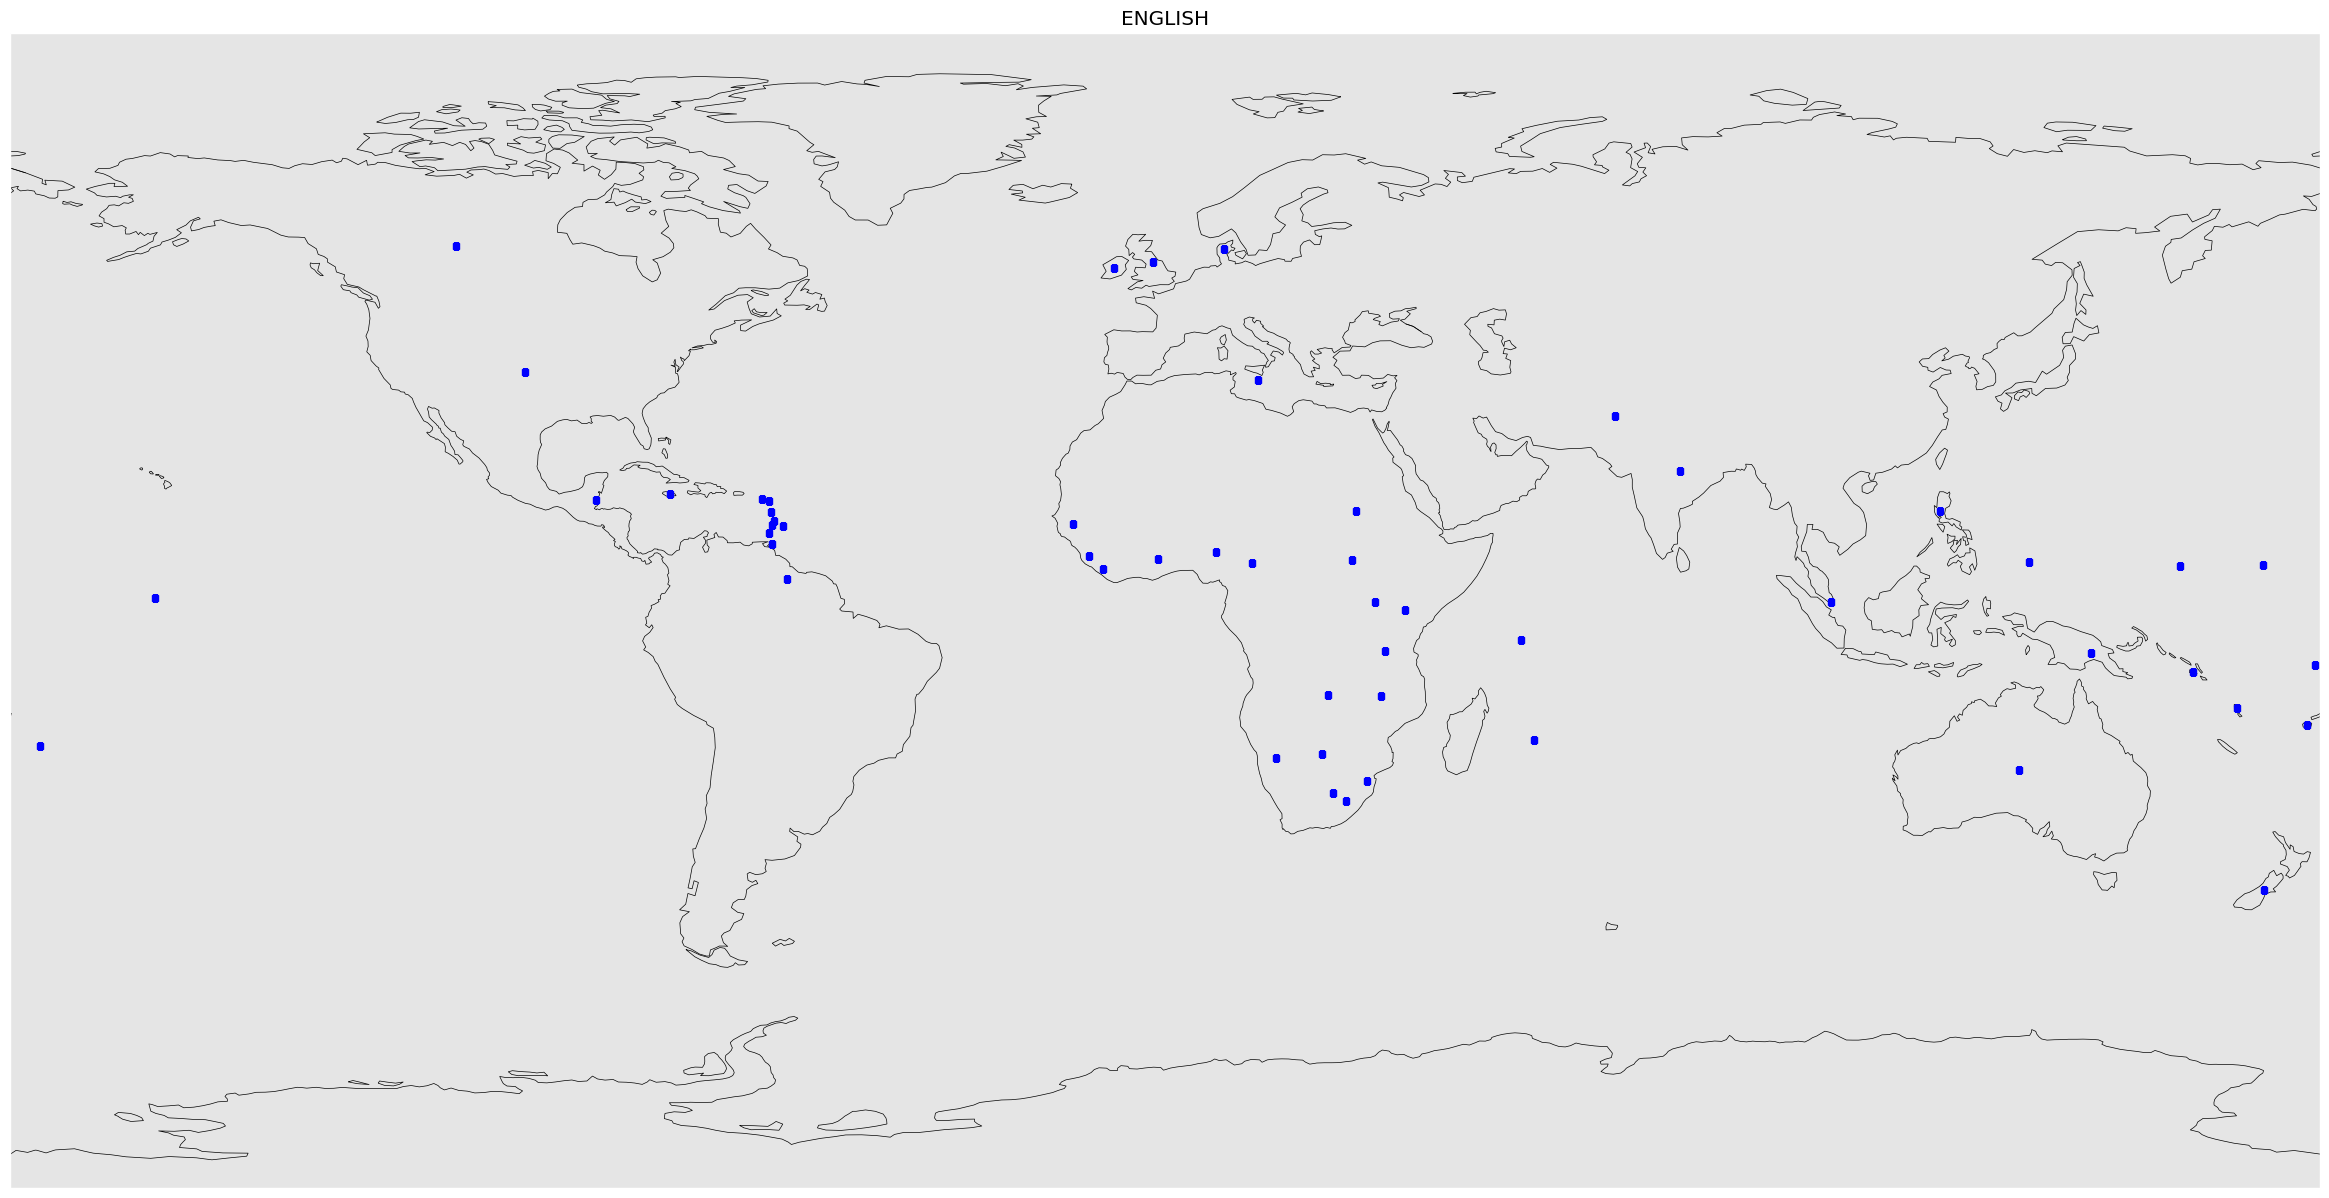

In [82]:
plot_countries(english.group_by("COUNTRY").first(), 'ENGLISH')

shape: (8,)
Series: 'COUNTRY' [str]
[
	"Angola"
	"Brazil"
	"Cape Verde"
	"East Timor"
	"Guinea Bissau"
	"Mozambique"
	"Portugal"
	"Sao Tome and Principe"
]


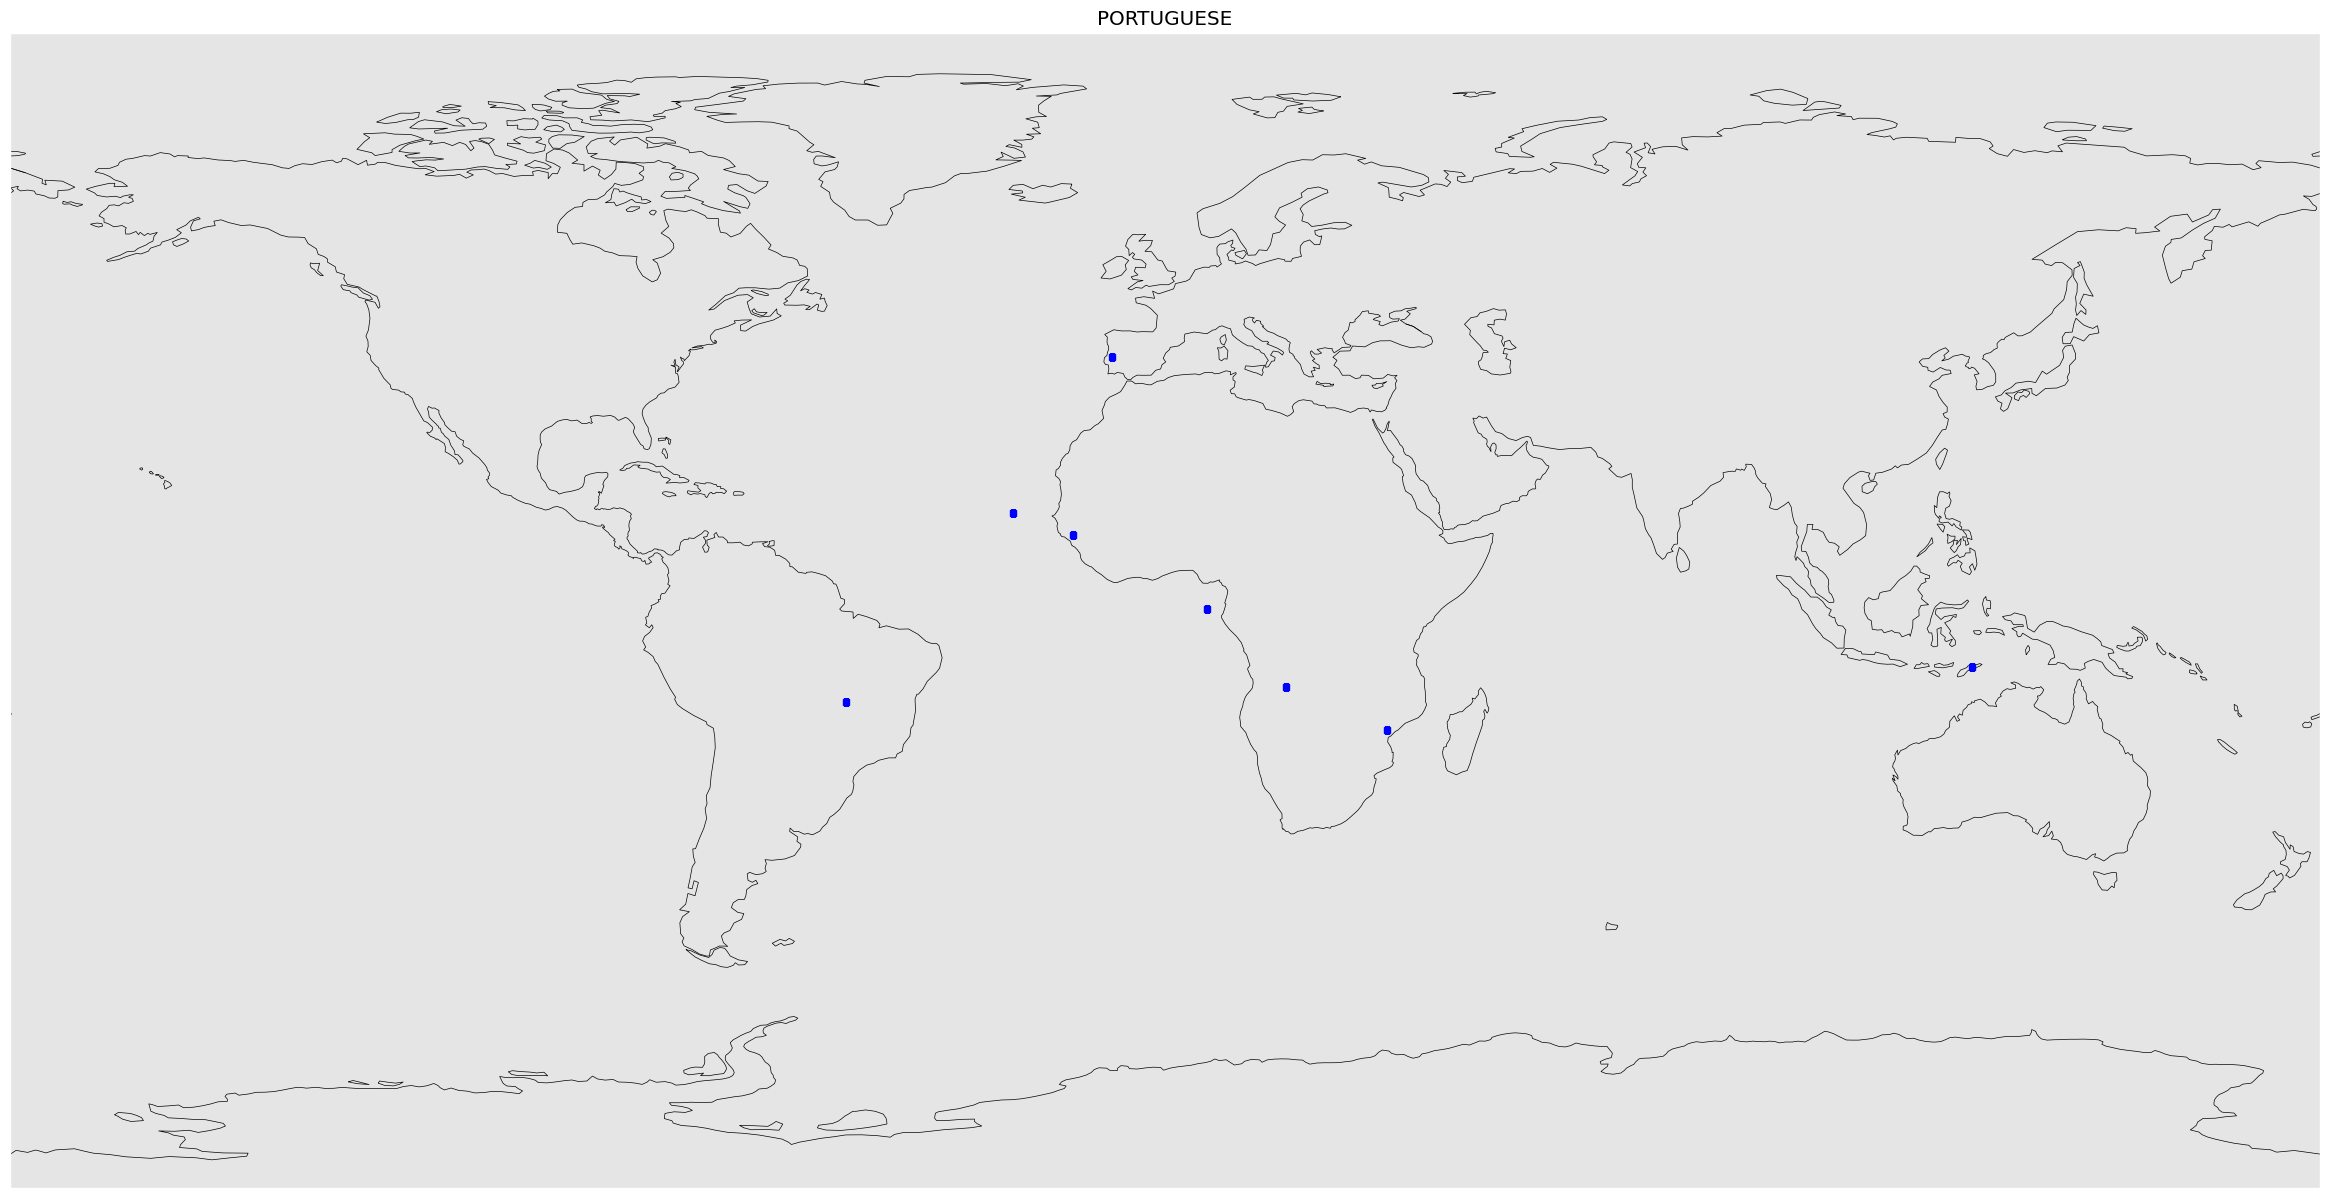

In [83]:
portuguese=langs.filter(((langs['FIRST_OFFI'] == 'Portuguese') | (langs['SECOND_OFF'] == 'Portuguese')) 
                    & ((langs['TYPE_'] == 'Sovereign country')|(langs['TYPE_'] == 'Country'))
                    & (langs['SOVEREIGNT'] == langs['COUNTRY'])
                    )
print(portuguese['COUNTRY'].unique().sort())
plot_countries(portuguese.group_by("COUNTRY").first(), 'PORTUGUESE')

shape: (3,)
Series: 'COUNTRY' [str]
[
	"Belgium"
	"Netherlands"
	"Suriname"
]


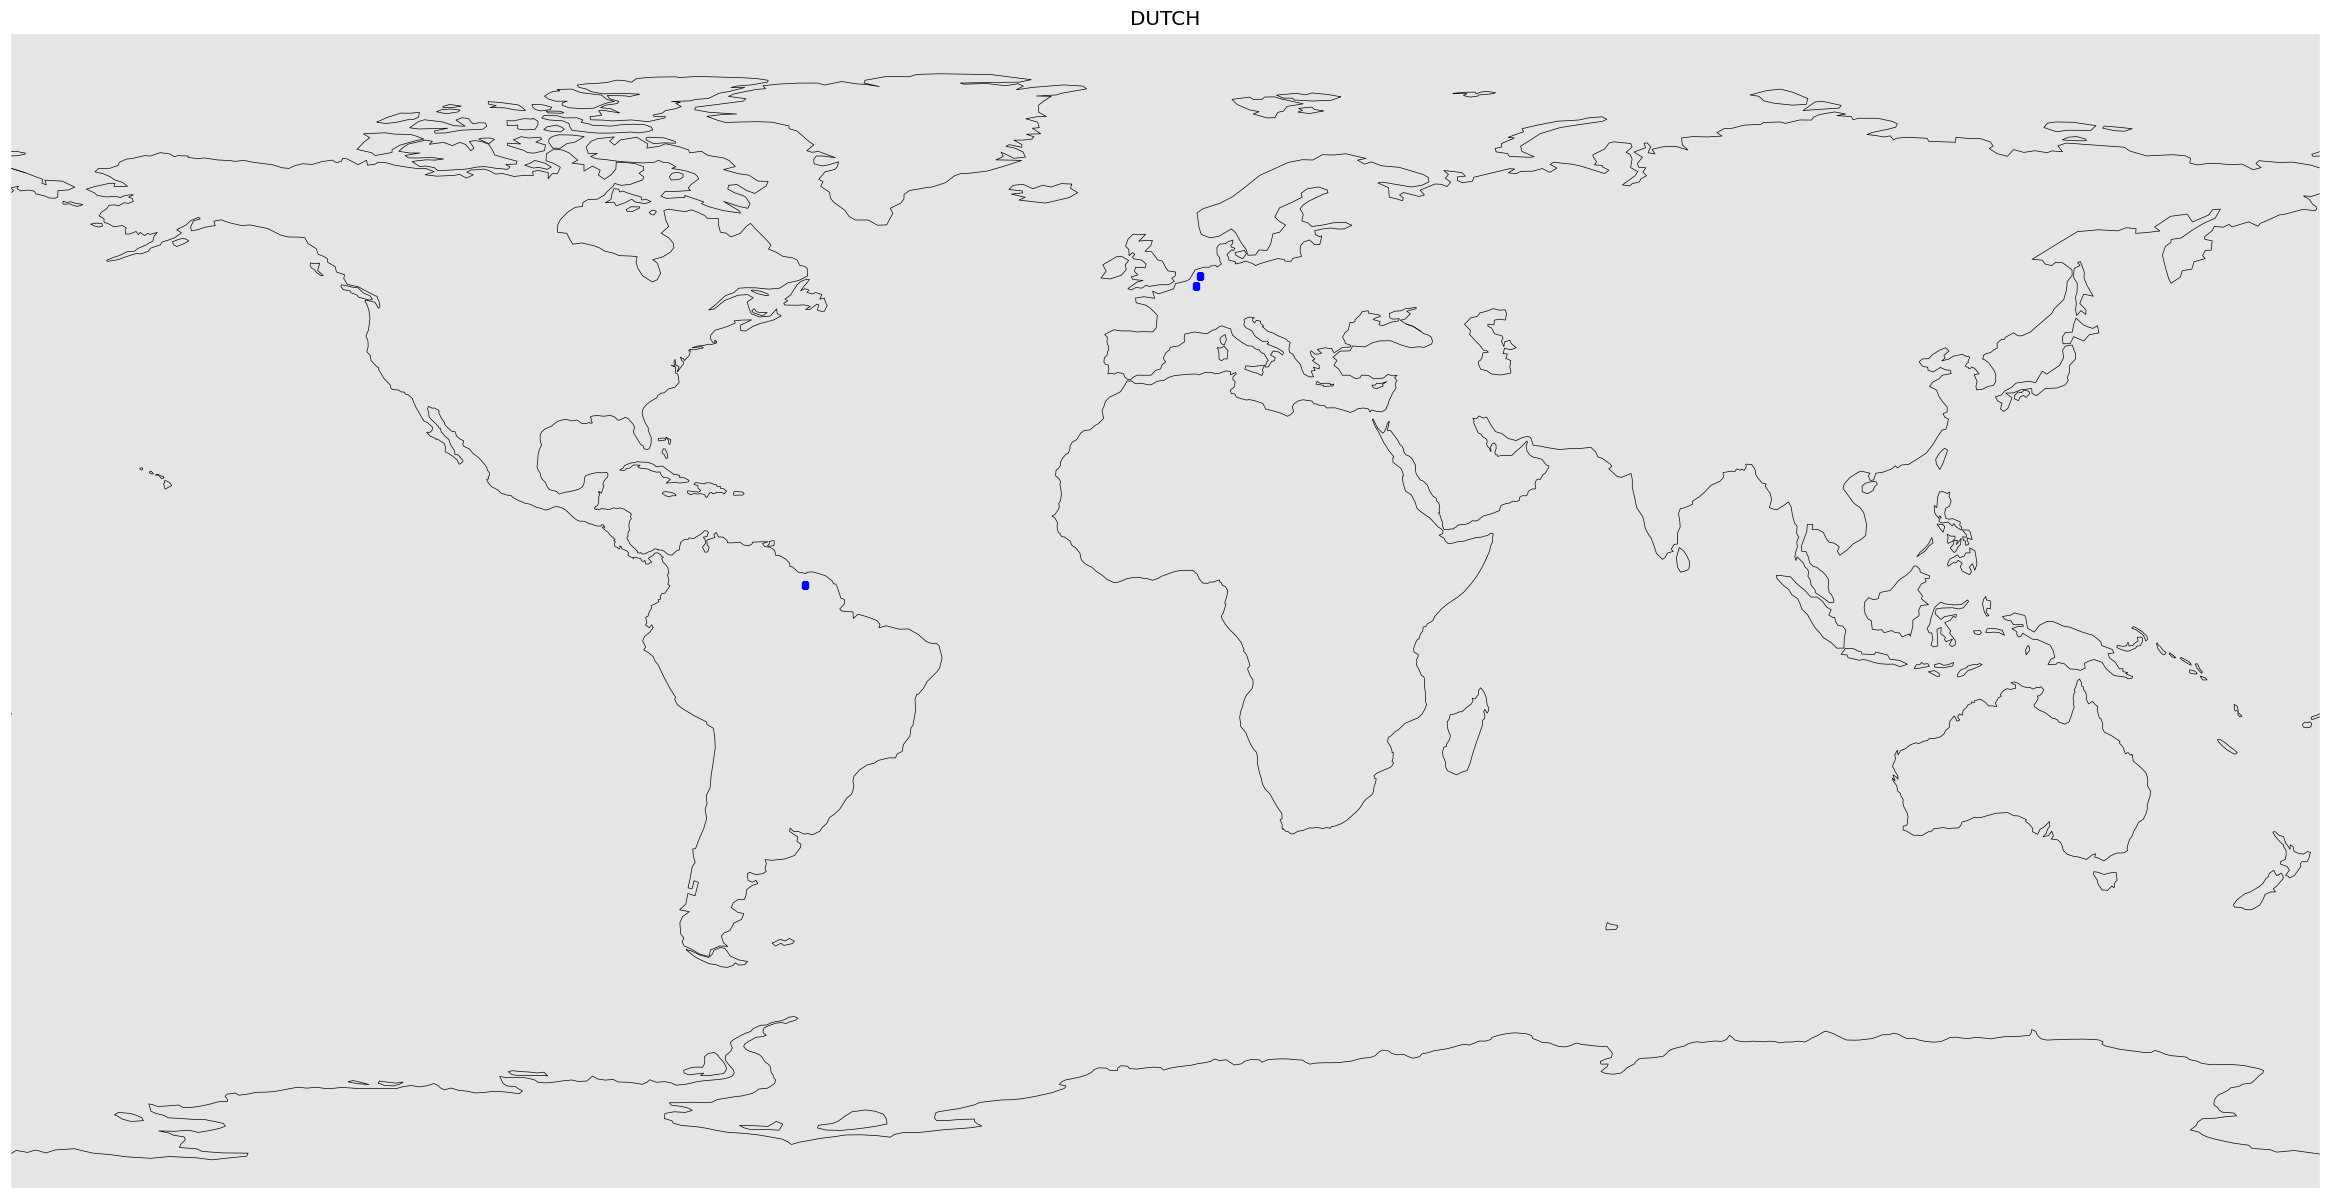

In [84]:
dutch=langs.filter(((langs['FIRST_OFFI'] == 'Dutch') | (langs['SECOND_OFF'] == 'Dutch')) 
                    & ((langs['TYPE_'] == 'Sovereign country')|(langs['TYPE_'] == 'Country'))
                    & (langs['SOVEREIGNT'] == langs['COUNTRY'])
                    )
print(dutch['COUNTRY'].unique().sort())
plot_countries(dutch.group_by("COUNTRY").first(), 'DUTCH')

shape: (4,)
Series: 'COUNTRY' [str]
[
	"Austria"
	"Germany"
	"Liechtenstein"
	"Switzerland"
]


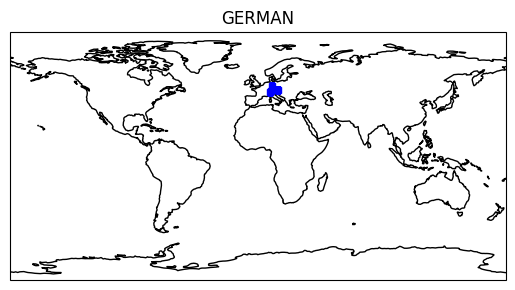

In [10]:
german=langs.filter(((langs['FIRST_OFFI'] == 'German') | (langs['SECOND_OFF'] == 'German')) 
                    & ((langs['TYPE_'] == 'Sovereign country')|(langs['TYPE_'] == 'Country'))
                    & (langs['SOVEREIGNT'] == langs['COUNTRY'])
                    )
print(german['COUNTRY'].unique().sort())
plot_countries(german.group_by("COUNTRY").first(), 'GERMAN')